<h1>Twitter Data</h1>

<h3>Installation and import of libraries</h3>

In [7]:
folder_path = "../Twitter_Data/"
output_folder_path = "./"
file1 = "Twitter_Covid-19_Lockdown_5000.csv"
file2 = "Twitter_Jan_Mar_5000.csv"
file3 = "Twitter_Mar_5000.csv"
file4 = "Twitter_May_Nov_5000.csv"

In [8]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

import nltk
nltk.download('stopwords') #download if don't have yet
from nltk.tokenize import word_tokenize, RegexpTokenizer # tokenize words
from nltk.corpus import stopwords

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<h3>Viewing Data</h3>

In [10]:
twitter_lockdown_df = pd.read_csv(folder_path + file1)
twitter_jan_mar_df = pd.read_csv(folder_path + file2)
twitter_mar_df = pd.read_csv(folder_path + file3)
twitter_may_nov_df = pd.read_csv(folder_path + file4)

print(twitter_lockdown_df.columns)
print(twitter_jan_mar_df.columns)
print(twitter_mar_df.columns)
print(twitter_may_nov_df.columns)

Index(['author_id', 'conversation_id', 'id', 'edit_history_tweet_ids', 'text',
       'created_at', 'withheld.copyright', 'withheld.country_codes',
       'author_name', 'orginal_text', 'original_text'],
      dtype='object')
Index(['Datetime', 'Tweet Id', 'Text', 'Username', 'Coordinates', 'Place'], dtype='object')
Index(['Datetime', 'Tweet Id', 'Text', 'Username', 'Coordinates', 'Place'], dtype='object')
Index(['Datetime', 'Tweet Id', 'Text', 'Username', 'Coordinates', 'Place'], dtype='object')


In [11]:
# Drop columns mentioning Bheed trailer
twitter_lockdown_df = twitter_lockdown_df[ twitter_lockdown_df["text"].str.contains("Bheed")==False]
twitter_jan_mar_df = twitter_jan_mar_df[ twitter_jan_mar_df["Text"].str.contains("Bheed")==False]
twitter_mar_df = twitter_mar_df[ twitter_mar_df["Text"].str.contains("Bheed")==False]
twitter_may_nov_df = twitter_may_nov_df[ twitter_may_nov_df["Text"].str.contains("Bheed")==False]

<h3>Cleaning Data</h3>

In [12]:
def remove_user_mentions(text):
    return re.sub("@[A-Za-z0-9_]+","", text)

def remove_links(text):
    return re.sub(r'http\S+', '', text)

def remove_digit_strings(text):
    return re.sub(r'\d+', '', text)

def remove_special_chars(text):
    remove_chars = '[0-9’!"#$%&\'()*+,-./:;<=>?@，。?★、…【】《》？“”‘’！[\\]^_`{|}~]+'
    return re.sub(remove_chars, ' ', text)

def clean_text(text):
    result_text = text
    result_text = remove_user_mentions(result_text)
    result_text = remove_links(result_text)
    result_text = remove_digit_strings(result_text)
    result_text = remove_special_chars(result_text)
    result_text = result_text.lower()
    return result_text

In [13]:
'''
Clean text, and check for empty strings / strings containing only whitespace
'''
texts = twitter_lockdown_df["text"].tolist() + twitter_jan_mar_df["Text"].tolist() + twitter_mar_df["Text"].tolist() + twitter_may_nov_df["Text"].tolist()
for i in range(len(texts)):
    texts[i] = clean_text(texts[i])

In [14]:
print(len(texts))
print(texts[0])
print(texts[1])

14144
rt   today marks three years since the uk went into lockdown   

on this national day of reflection  i visited the  
 i used play fortnite a lot on my android in covid   lockdown and chapter  midas revenge was the best one


<h3>Tokenizing Data</h3>

In [15]:
# Stopwords
stop_words = stopwords.words('english')
exclude_words = stop_words

#exclude common words 
exclude_words_extra = ["RT","still","covid","coronavirus","lockdown","lockdo","pandemic","let","get","ago","go","im","ive","would","one","also","to","tag"]

exclude_words.extend(exclude_words_extra)

In [16]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(texts))

In [17]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['rt_today_marks', 'three_years_since', 'the', 'uk', 'went_into', 'lockdown', 'on', 'this', 'national', 'day', 'of', 'reflection', 'visited', 'the']


In [18]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in exclude_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [19]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['go', 'national', 'day', 'reflection', 'visit']]


In [20]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]]


[[('day', 1), ('go', 1), ('national', 1), ('reflection', 1), ('visit', 1)]]

<h3>LDA Model</h3>

In [21]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

# supporting function 2
def compute_perplexity_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    perplexity_score = lda_model.log_perplexity(corpus_sets[i])
    
    return perplexity_score

In [22]:
# Build LDA model
num_topics = 4
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [23]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.031*"day" + 0.015*"tier" + 0.015*"need" + 0.015*"time" + 0.015*"go" + '
  '0.013*"government" + 0.013*"end" + 0.013*"see" + 0.013*"week" + '
  '0.013*"come"'),
 (1,
  '0.047*"people" + 0.023*"death" + 0.016*"home" + 0.015*"make" + '
  '0.014*"think" + 0.013*"due" + 0.011*"health" + 0.010*"impose" + '
  '0.010*"close" + 0.010*"state"'),
 (2,
  '0.022*"say" + 0.016*"die" + 0.014*"country" + 0.011*"rise" + '
  '0.010*"interview" + 0.010*"read" + 0.009*"number" + 0.009*"get" + '
  '0.009*"spread" + 0.008*"good"'),
 (3,
  '0.019*"new" + 0.016*"case" + 0.011*"year" + 0.011*"restriction" + '
  '0.010*"take" + 0.010*"work" + 0.009*"help" + 0.009*"amp" + 0.009*"woman" + '
  '0.009*"violence"')]


In [24]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.081663422356895

Coherence Score:  0.3471080792640732


In [25]:
optimal_model = lda_model
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.031*"day" + 0.015*"tier" + 0.015*"need" + 0.015*"time" + 0.015*"go" + '
  '0.013*"government" + 0.013*"end" + 0.013*"see" + 0.013*"week" + '
  '0.013*"come"'),
 (1,
  '0.047*"people" + 0.023*"death" + 0.016*"home" + 0.015*"make" + '
  '0.014*"think" + 0.013*"due" + 0.011*"health" + 0.010*"impose" + '
  '0.010*"close" + 0.010*"state"'),
 (2,
  '0.022*"say" + 0.016*"die" + 0.014*"country" + 0.011*"rise" + '
  '0.010*"interview" + 0.010*"read" + 0.009*"number" + 0.009*"get" + '
  '0.009*"spread" + 0.008*"good"'),
 (3,
  '0.019*"new" + 0.016*"case" + 0.011*"year" + 0.011*"restriction" + '
  '0.010*"take" + 0.010*"work" + 0.009*"help" + 0.009*"amp" + 0.009*"woman" + '
  '0.009*"violence"')]


In [26]:
def explore_topic(lda_model, topic_number, topn, output=True):
    """
    accept a ldamodel, atopic number and topn vocabs of interest
    prints a formatted list of the topn terms
    """
    terms = []
    for term, frequency in lda_model.show_topic(topic_number, topn=topn):
        terms += [term]
        if output:
            print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))
    
    return terms

In [27]:
topic_summaries = []
print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(4):
    print('Topic '+str(i)+' |---------------------\n')
    tmp = explore_topic(lda_model,topic_number=i, topn=10, output=True )
#     print tmp[:5]
    topic_summaries += [tmp[:5]]
    print

term                 frequency

Topic 0 |---------------------

day                  0.031
tier                 0.015
need                 0.015
time                 0.015
go                   0.015
government           0.013
end                  0.013
see                  0.013
week                 0.013
come                 0.013
Topic 1 |---------------------

people               0.047
death                0.023
home                 0.016
make                 0.015
think                0.014
due                  0.013
health               0.011
impose               0.010
close                0.010
state                0.010
Topic 2 |---------------------

say                  0.022
die                  0.016
country              0.014
rise                 0.011
interview            0.010
read                 0.010
number               0.009
get                  0.009
spread               0.009
good                 0.008
Topic 3 |---------------------

new                  0.019
cas

<h1>Dominant Topic</h1>

In [28]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

<ipython-input-28-f4478a66205d>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
<ipython-input-28-f4478a66205d>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0,0.3479,"day, tier, need, time, go, government, end, se...","[go, national, day, reflection, visit]"
1,1,3,0.4258,"new, case, year, restriction, take, work, help...","[use, play, fortnite, lot, android, revenge, w..."
2,2,3,0.2889,"new, case, year, restriction, take, work, help...","[tiktok, crisis, stay, home, order]"
3,3,3,0.3783,"new, case, year, restriction, take, work, help...","[time, change, course]"
4,4,3,0.4620,"new, case, year, restriction, take, work, help...","[feel, dump, tip, keep, top, mental_health]"
5,5,0,0.3414,"day, tier, need, time, go, government, end, se...","[speak, truth, shoot, faucilied_faucifile, age..."
6,6,3,0.4158,"new, case, year, restriction, take, work, help...","[book, prove, virus, intentional, publication,..."
7,7,3,0.3980,"new, case, year, restriction, take, work, help...","[nz, first, many, move, long]"
8,8,3,0.2889,"new, case, year, restriction, take, work, help...","[tiktok, crisis, stay, home, order]"
9,9,3,0.3980,"new, case, year, restriction, take, work, help...","[nz, first, many, move, long]"


<h1>Most Representative Sentence for each Topic</h1>

In [29]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.5101,"day, tier, need, time, go, government, end, see, week, come","[present, unprecedented, challenge, nhs, happen, today, reflect, positive, legacy, support, prov..."
1,1,0.4478,"people, death, home, make, think, due, health, impose, close, state","[artist, album, track, track, stay, home, track, track, quarantine, track, police, soldier, trac..."
2,2,0.5182,"say, die, country, rise, interview, read, number, get, spread, good","[extensie, verhoogd, tot, geweld, seksueel, misbruik, baanverlie, heeft, het, grote, schade, aan..."
3,3,0.6115,"new, case, year, restriction, take, work, help, amp, woman, violence","[case, last, day, new, case, march, new, case, march, new, case, march, new, case, march, new, c..."


<h1>Frequency Distribution of Word Counts in Documents</h1>

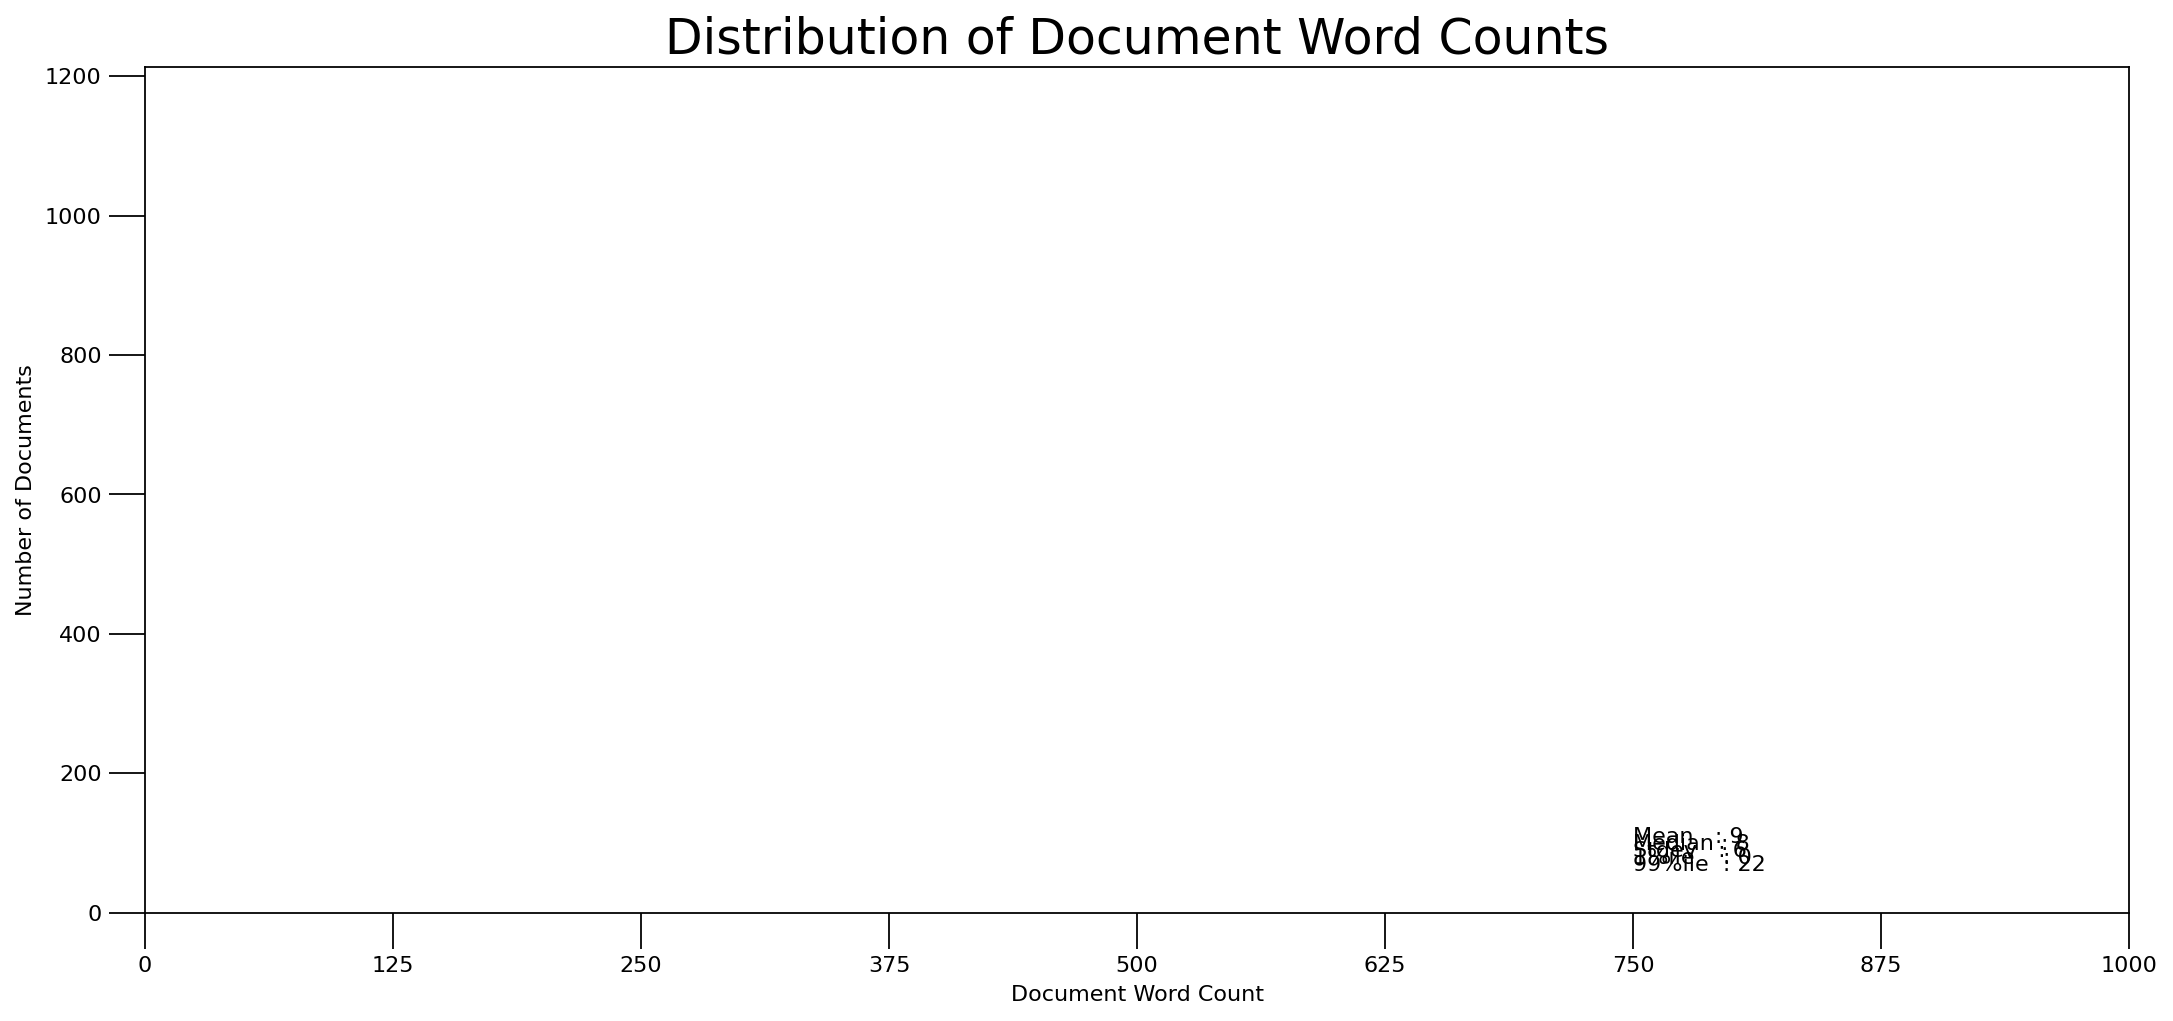

In [30]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

<ipython-input-31-cfc41bd4707a>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
<ipython-input-31-cfc41bd4707a>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
<ipython-input-31-cfc41bd4707a>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
<ipython-input-31-cfc41bd4707a>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens, col

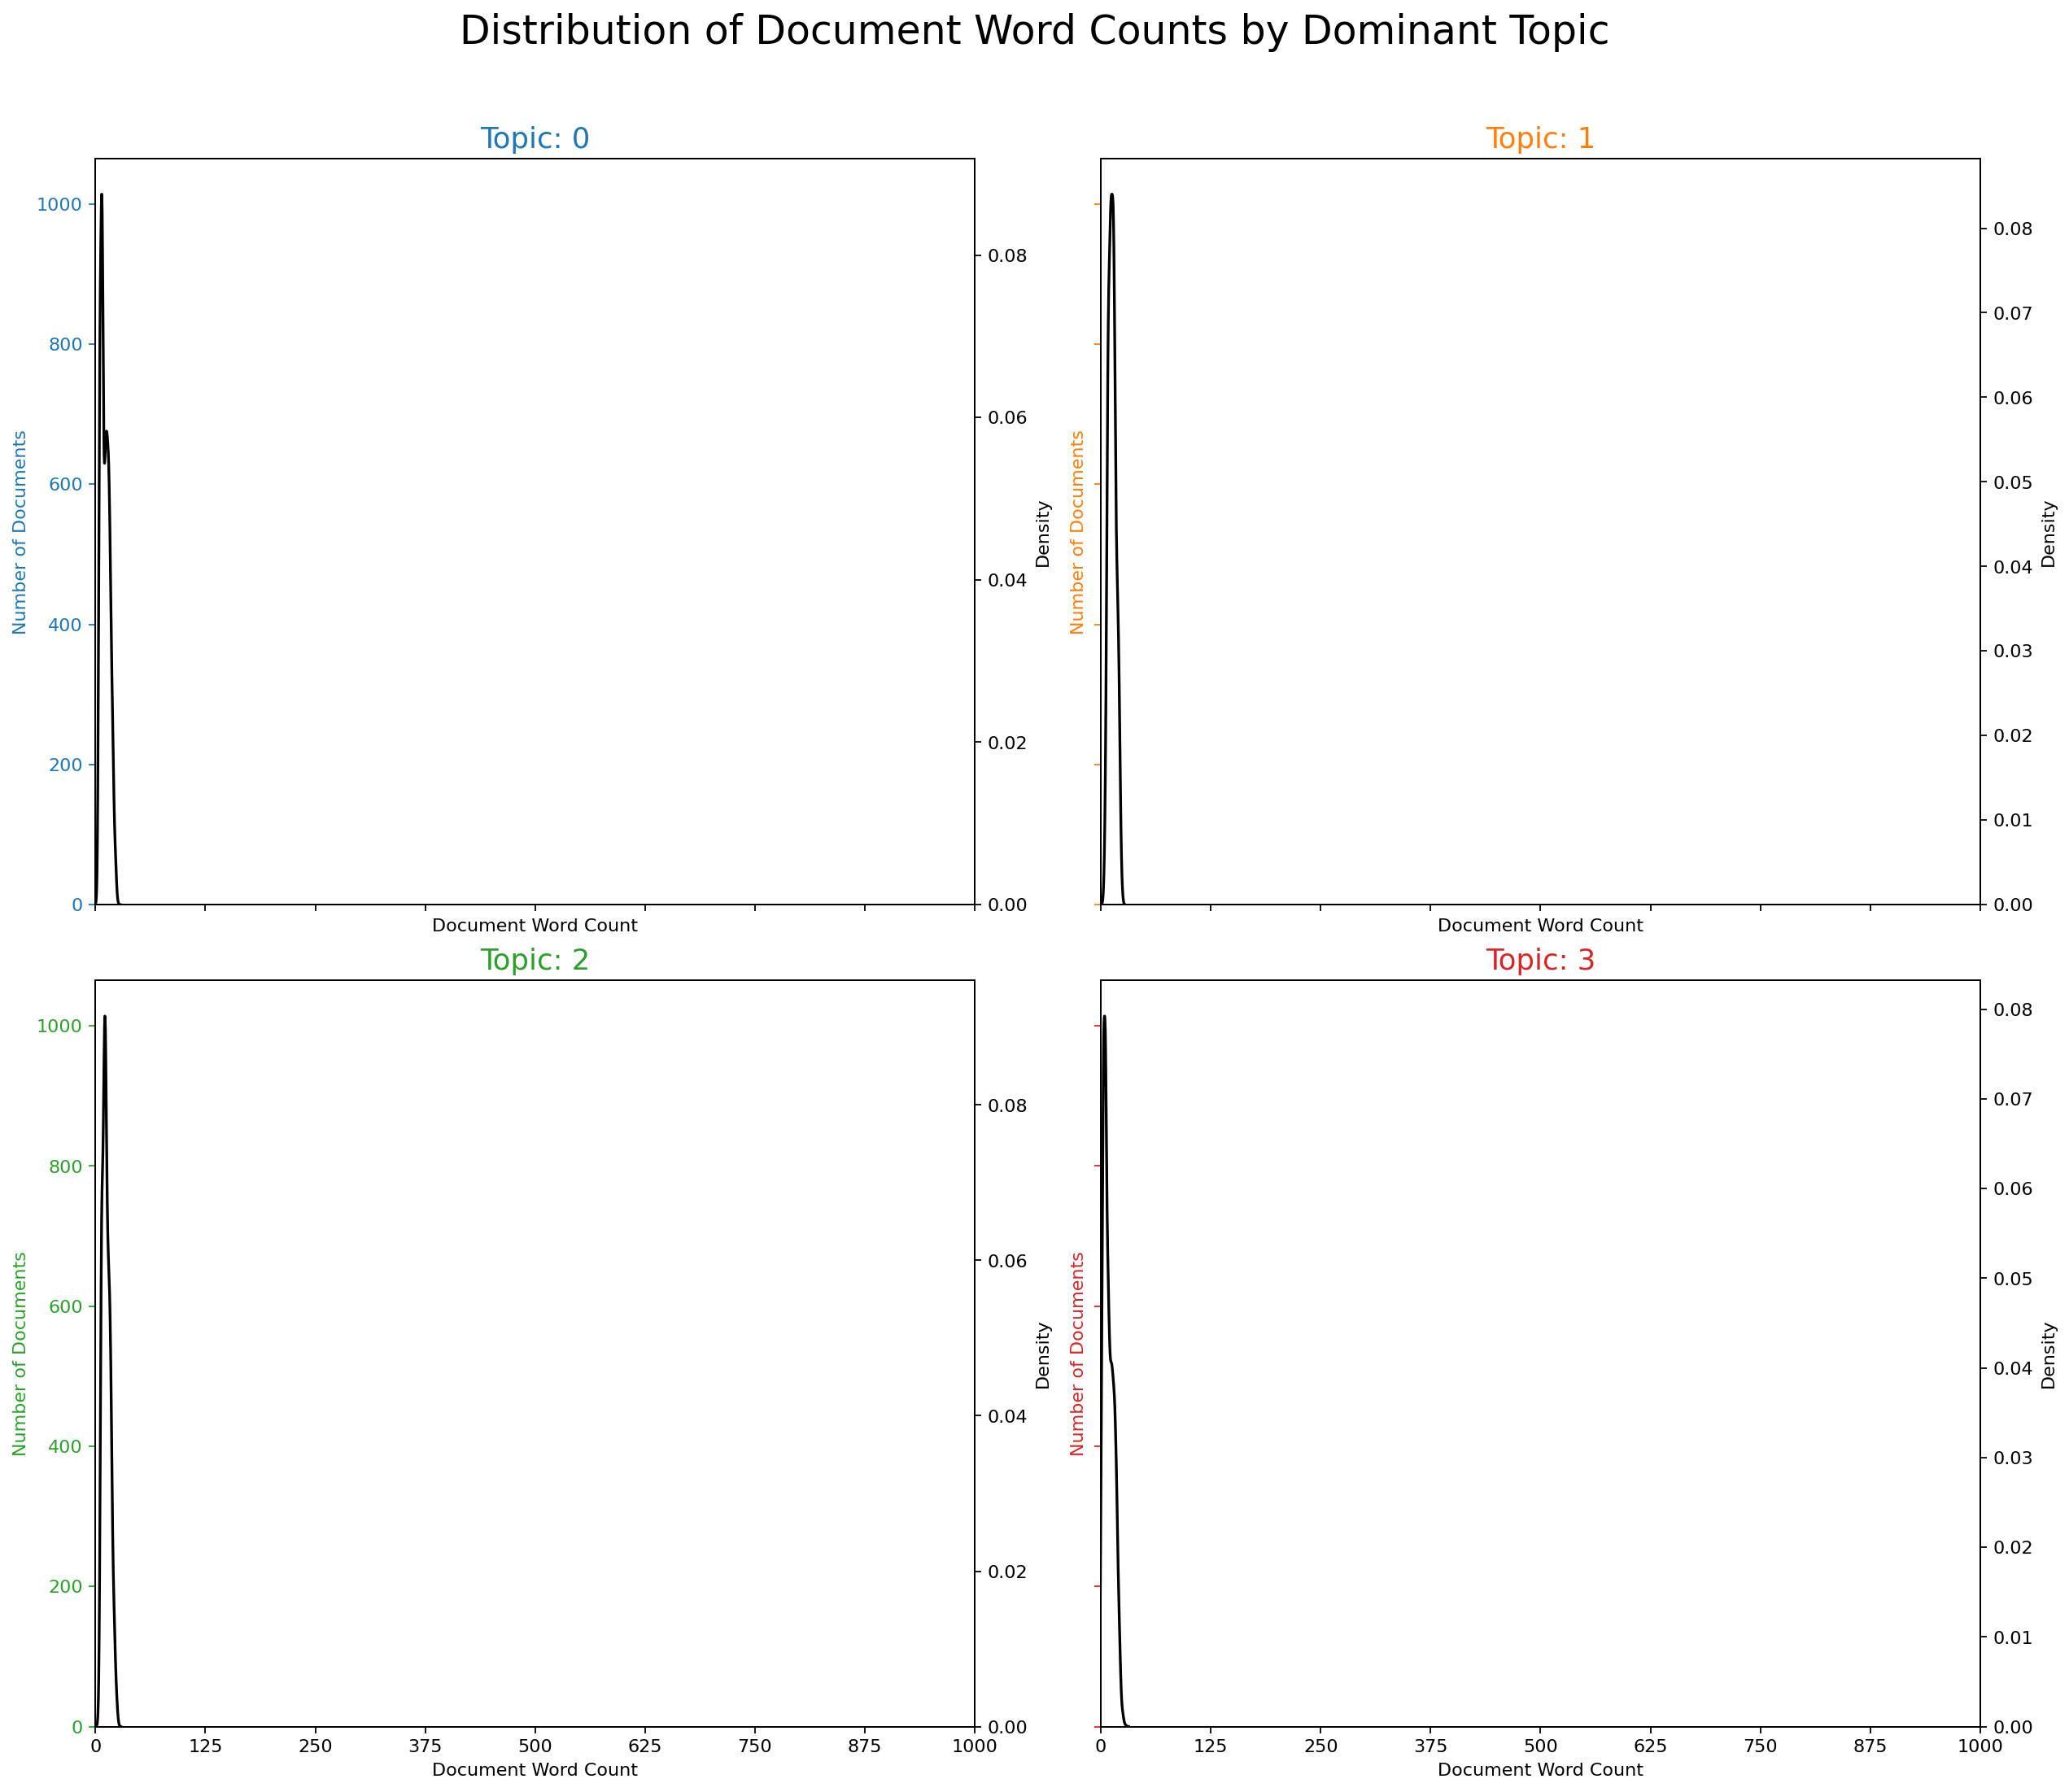

In [31]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

<h1>Word Clouds of Top N Keywords in Each Topic</h1>

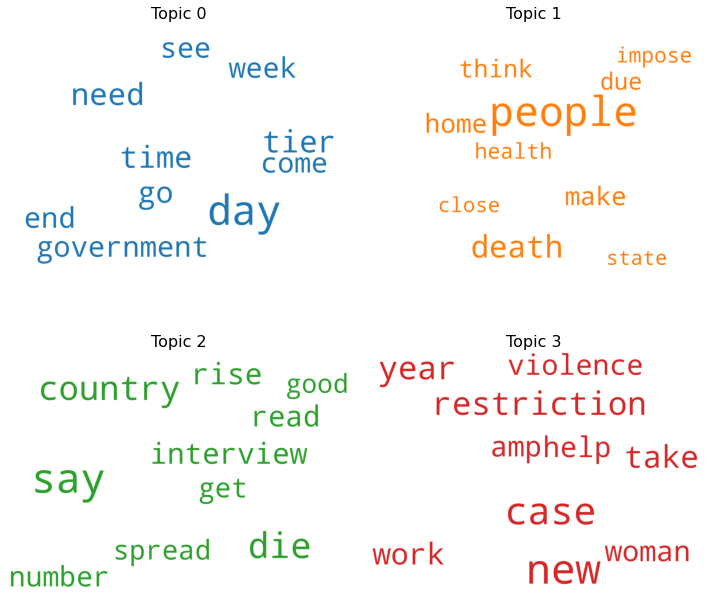

In [32]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

<h1>Word Counts of Topic Keywords</h1>

<ipython-input-33-80bdc80795d4>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


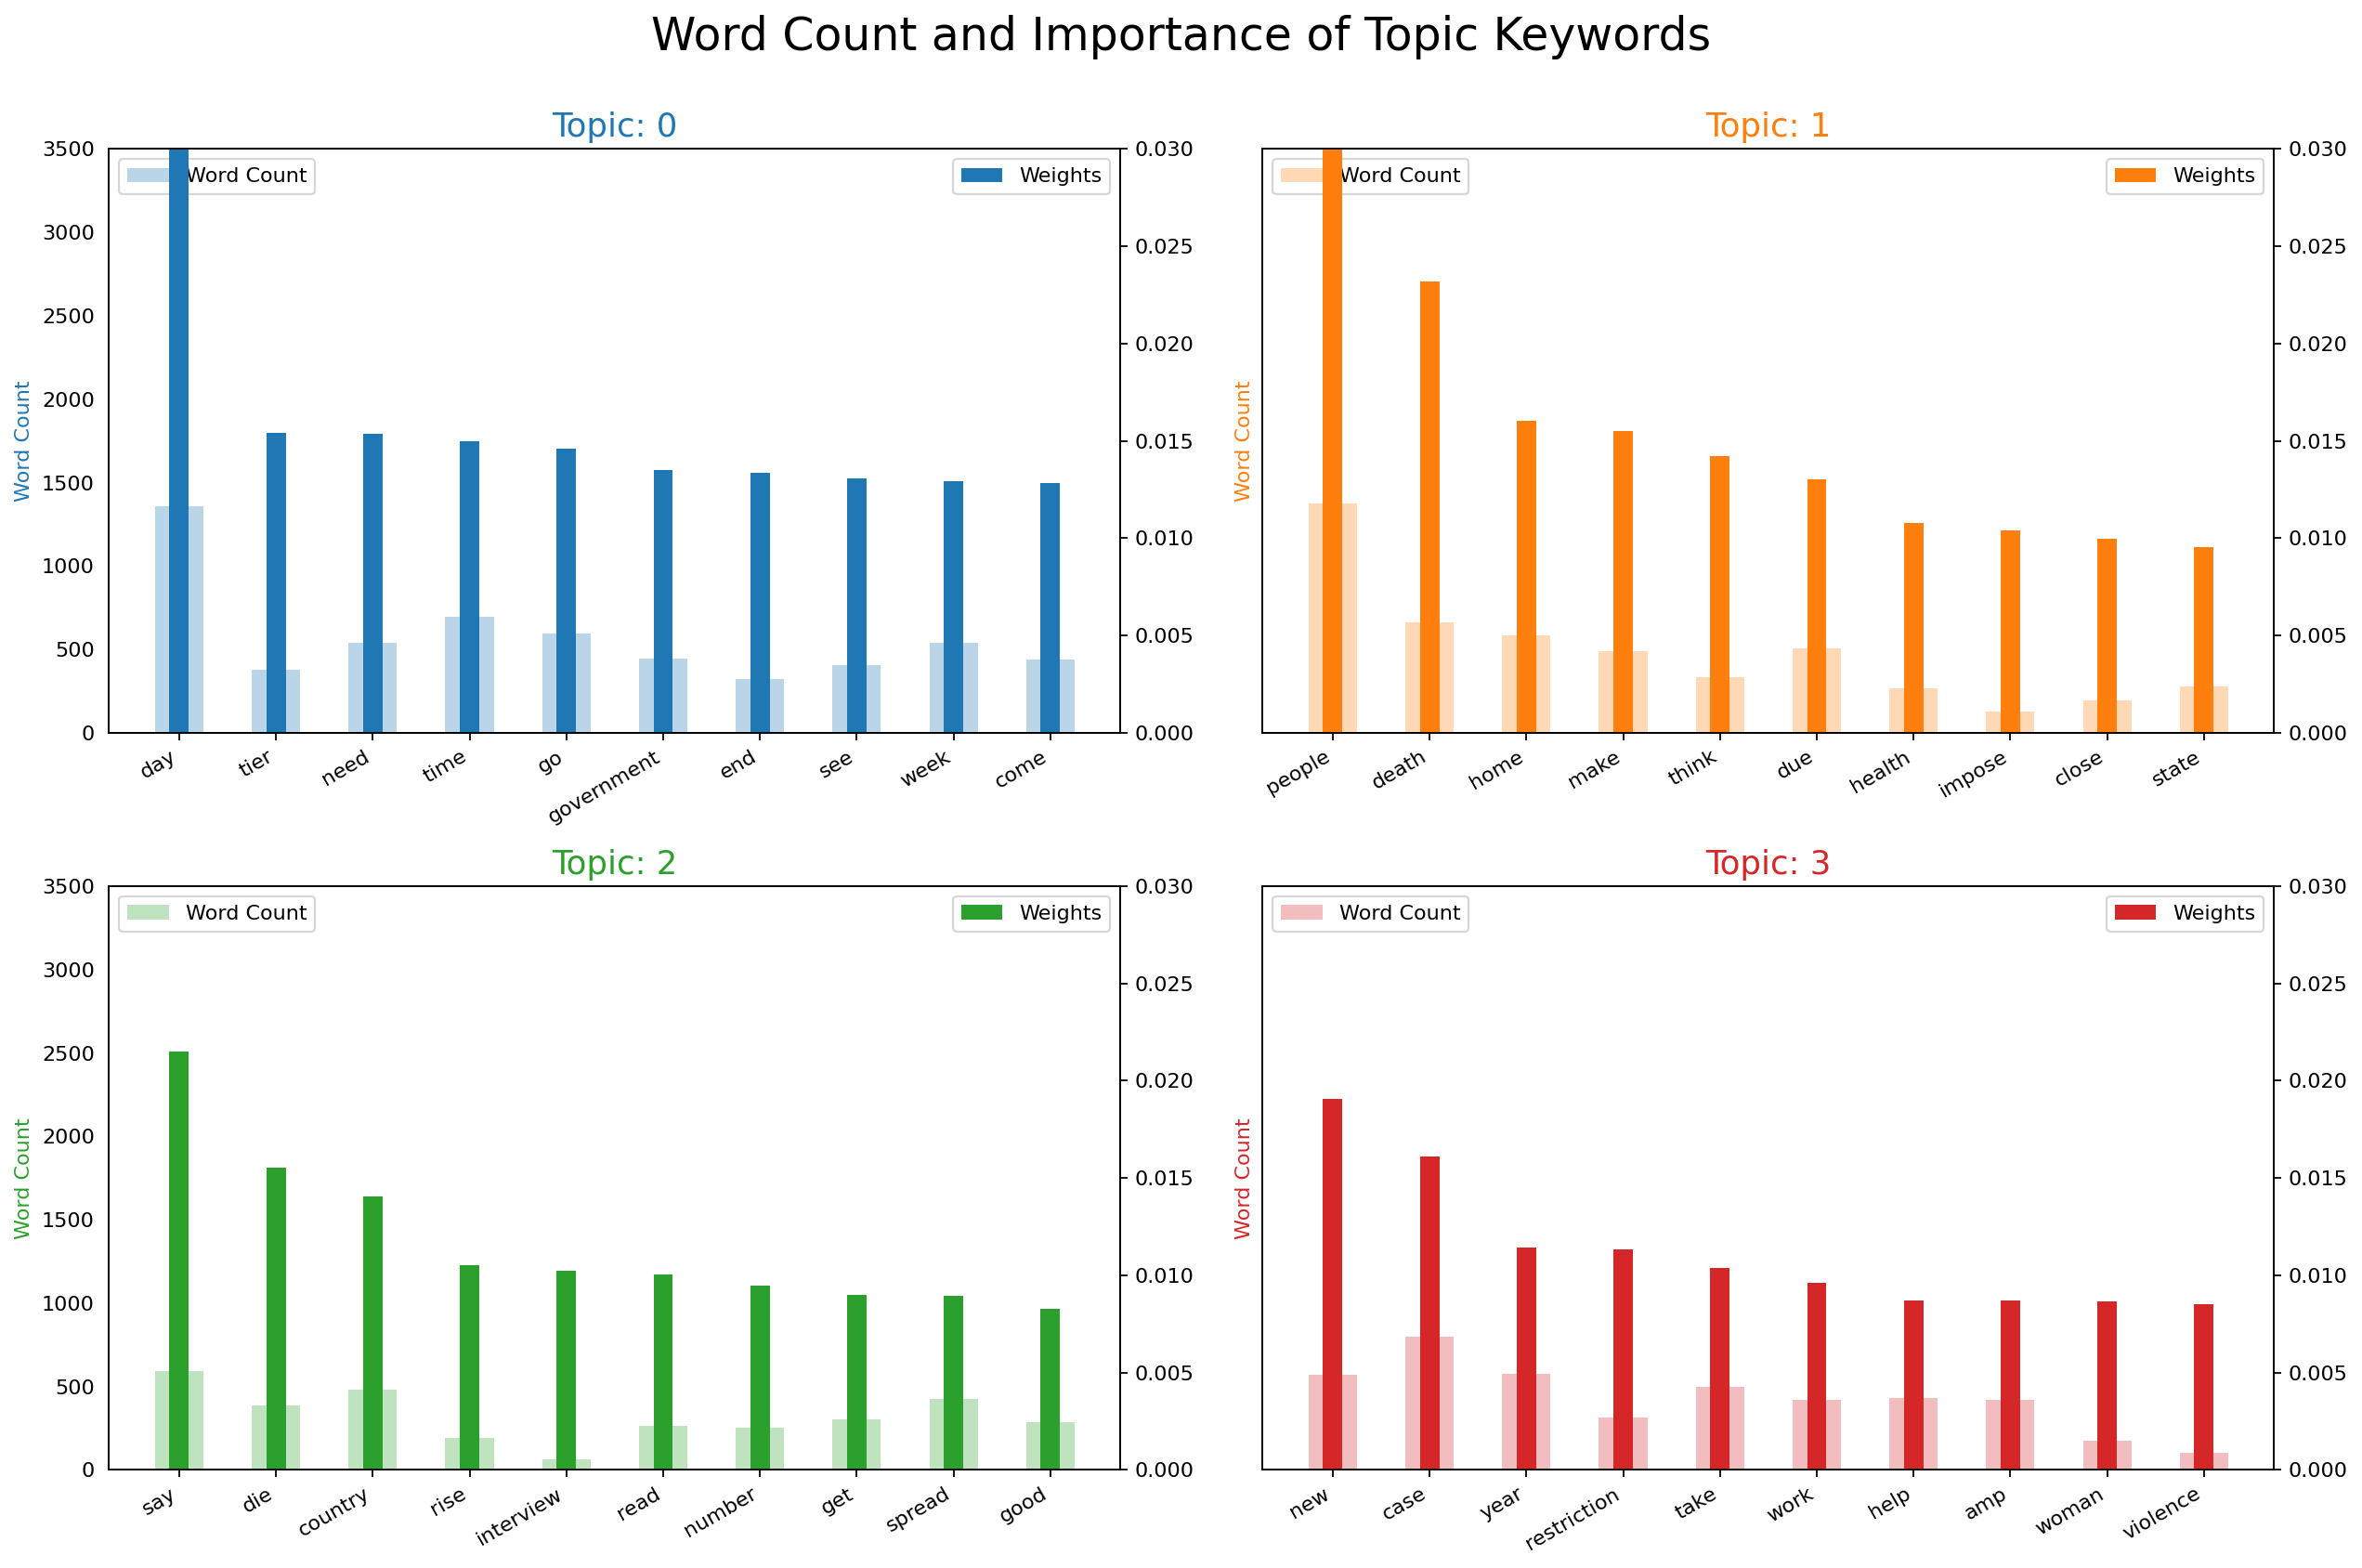

In [33]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

<h1>Sentence Chart Colored by Topic</h1>

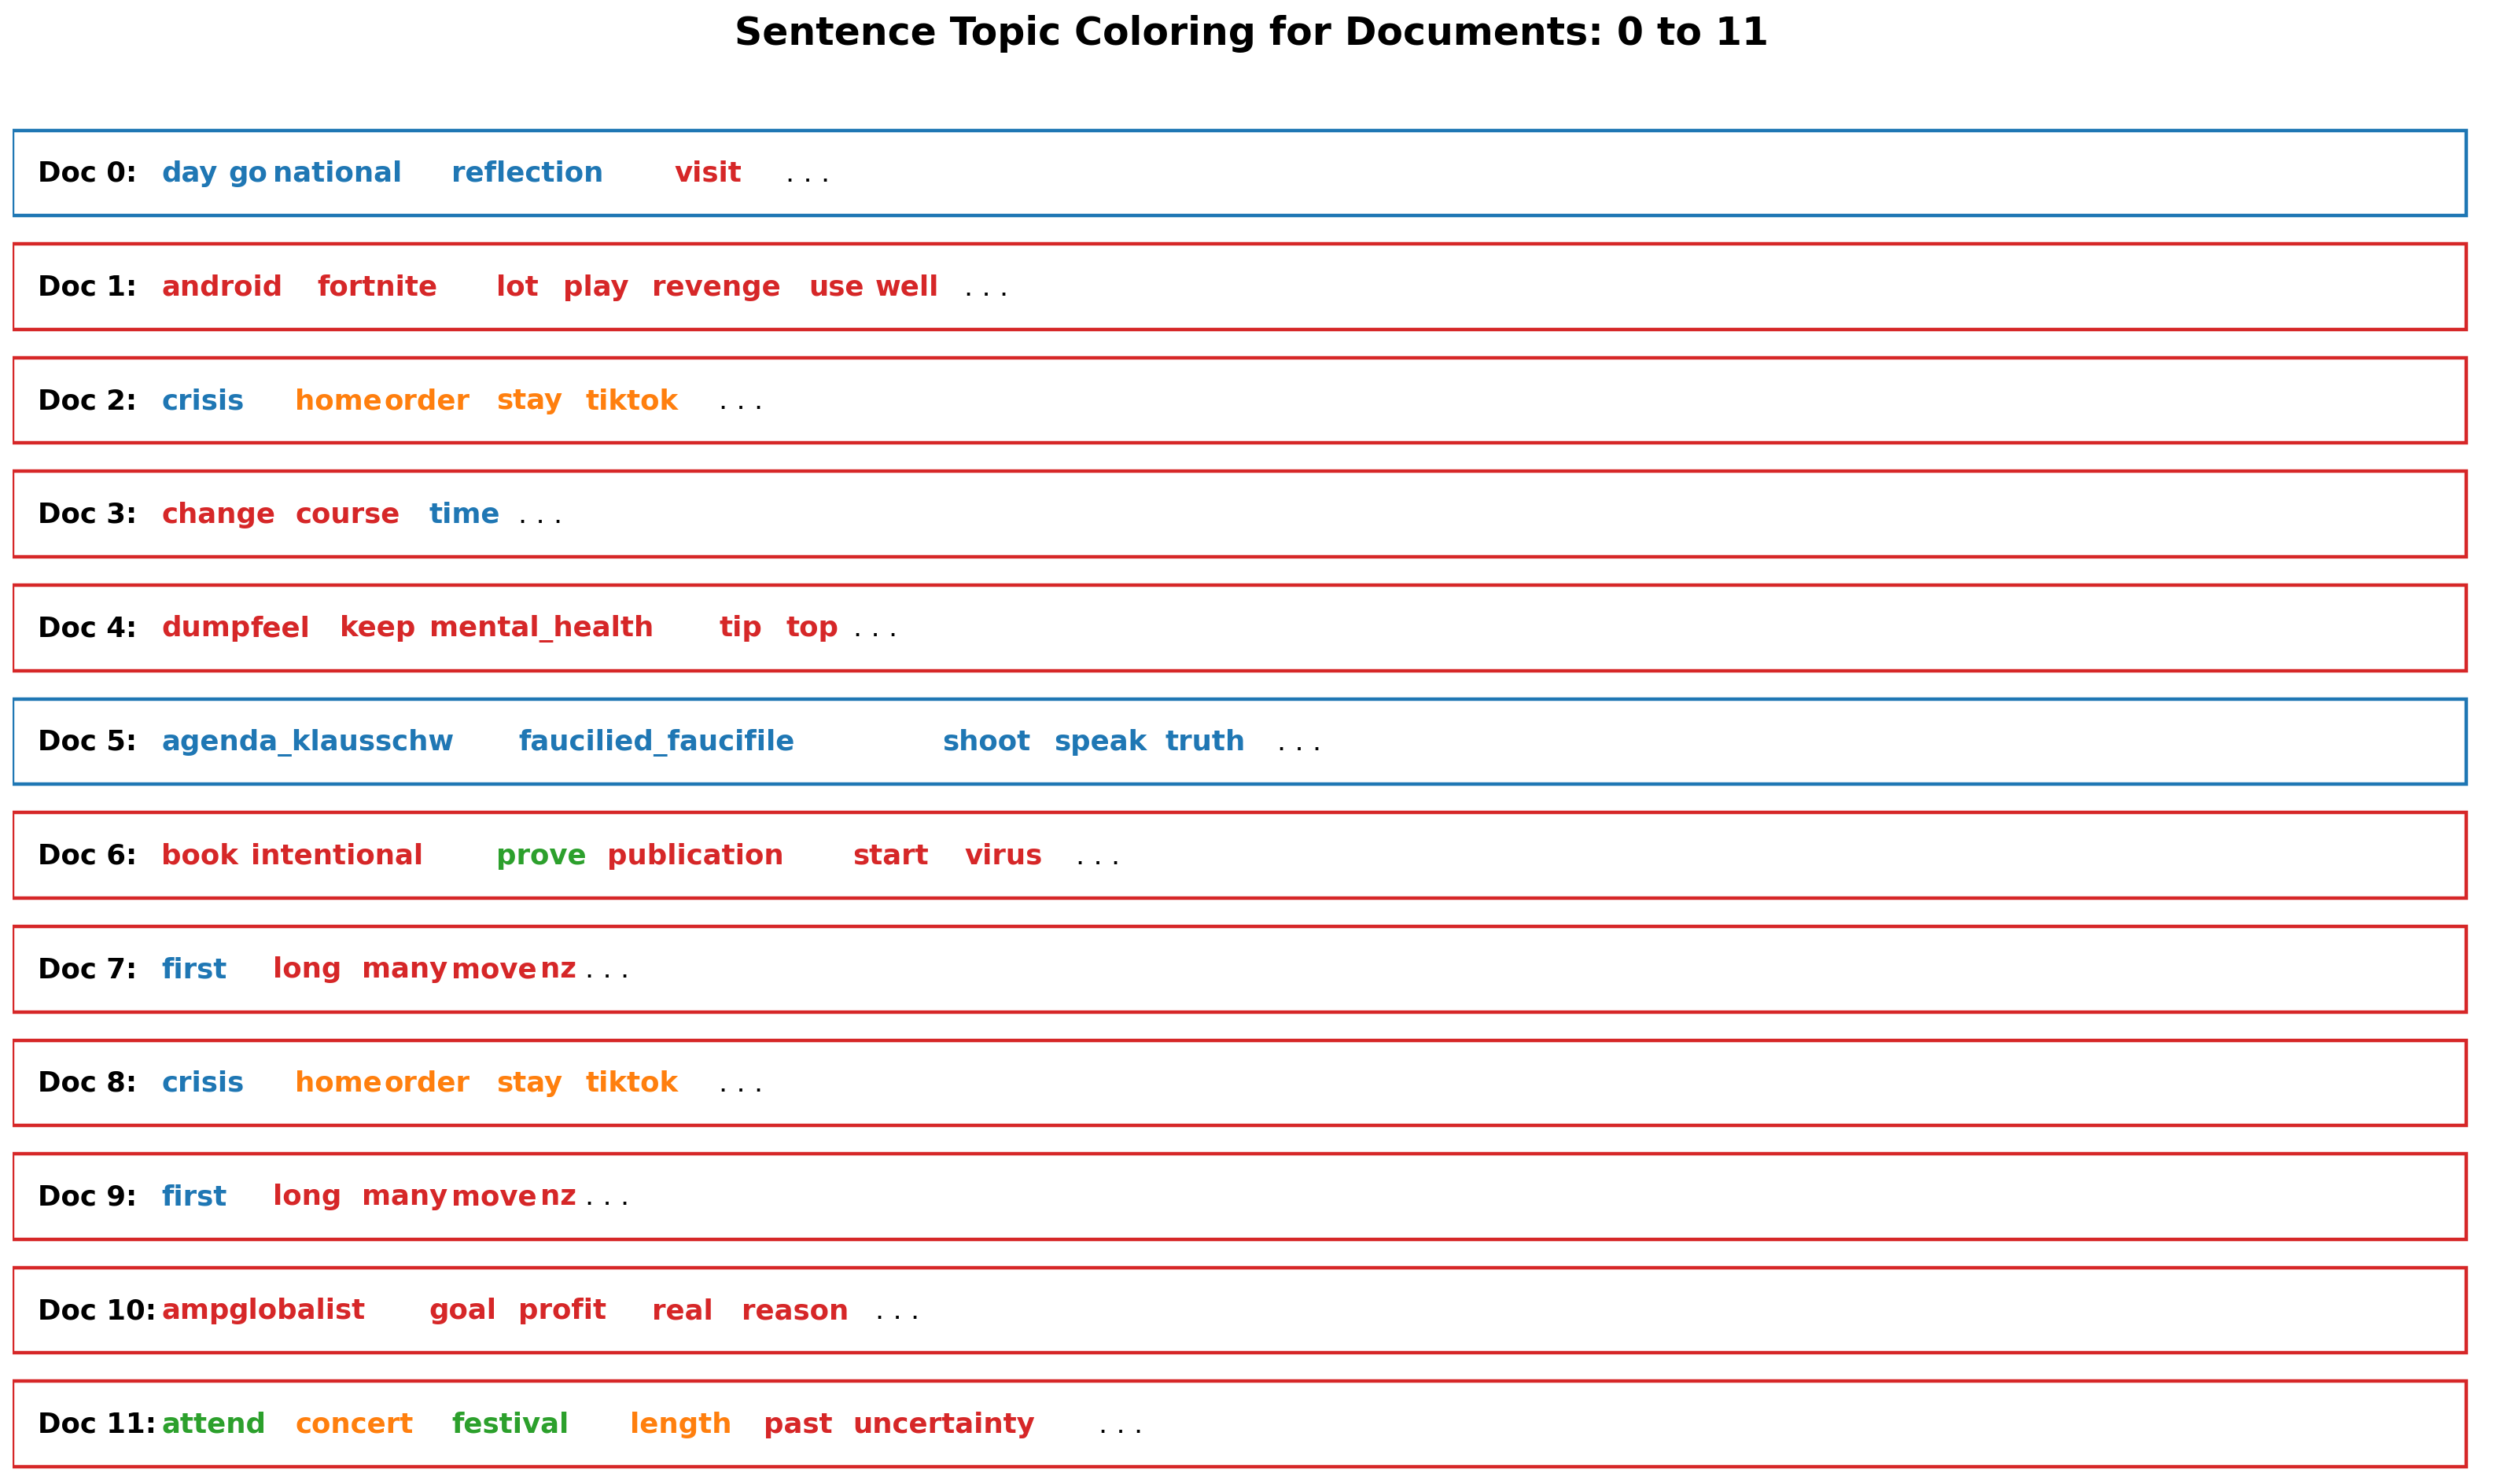

In [34]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()

<h1>What are the most discussed topics in the documents?</h1>

In [35]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

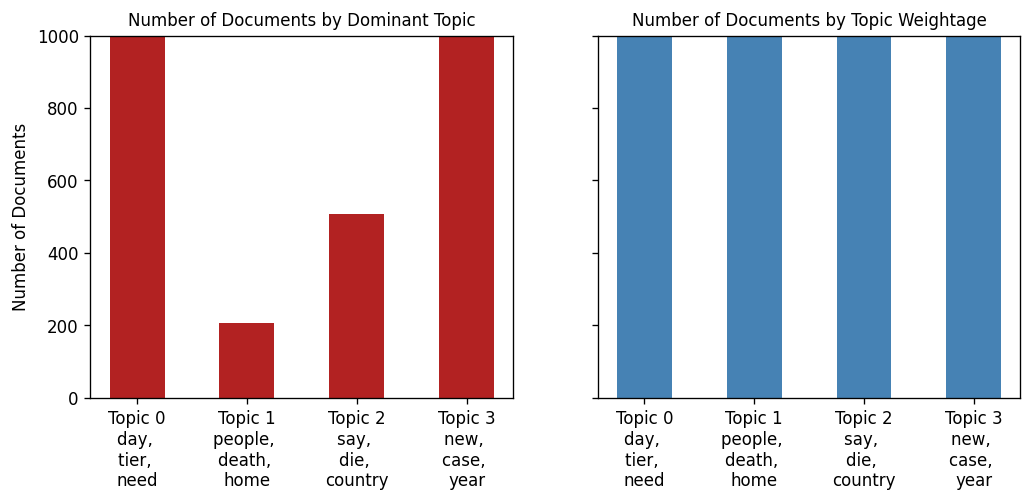

In [36]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

<h1>t-SNE Clustering Chart</h1>

In [37]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5980 samples in 0.003s...
[t-SNE] Computed neighbors for 5980 samples in 0.117s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5980
[t-SNE] Computed conditional probabilities for sample 2000 / 5980
[t-SNE] Computed conditional probabilities for sample 3000 / 5980
[t-SNE] Computed conditional probabilities for sample 4000 / 5980
[t-SNE] Computed conditional probabilities for sample 5000 / 5980
[t-SNE] Computed conditional probabilities for sample 5980 / 5980
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.221687
[t-SNE] KL divergence after 1000 iterations: 0.838311


<h1>pyLDAVis</h1>

In [38]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.304695  0.034727       1        1  34.651467
0     -0.143534  0.241283       2        1  26.221373
2     -0.094786 -0.201714       3        1  21.233341
1     -0.066375 -0.074295       4        1  17.893819, topic_info=         Term         Freq        Total Category  logprob  loglift
273    people  1091.000000  1091.000000  Default  30.0000  30.0000
0         day  1066.000000  1066.000000  Default  29.0000  29.0000
106     death   542.000000   542.000000  Default  28.0000  28.0000
135       say   598.000000   598.000000  Default  27.0000  27.0000
200       new   865.000000   865.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
110      seem    89.707218    90.377964   Topic4  -5.5636   1.7133
620    result    90.161776    90.854317   Topic4  -5.5586   1.7131
252      deal    86.896813    87.578398   Topic4  -5.5955   1.7129
477      lock    82.377371    83.044532   Topic4  -5.6489   1.7126
10102  bubble    84.136183    98.476457   Topic4  -5.6277   1.5633

[153 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
2049      3  0.998116  allow
42        1  0.998822    amp
548       2  0.998589   back
347       4  0.996554    bad
97        3  0.995110  break
...     ...       ...    ...
11        1  0.995710   well
1353      1  0.998369  woman
327       1  0.998512   work
72        1  0.998454  world
138       1  0.998721   year

[129 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 2])